# Le modele mathematique

Nous utilisons un modele compartimental pour simuler la transmission d'un pathogene dans une population humaine. Voir [ici](https://fr.wikipedia.org/wiki/Mod%C3%A8les_compartimentaux_en_%C3%A9pid%C3%A9miologie) pour plus d'infos.

### Le modele

Le [cholera](https://fr.wikipedia.org/wiki/Chol%C3%A9ra) se transmet par l'ingestion d'eau ou de la nourriture contamine. Nous allons utiliser [ce papier](http://www.math.ualberta.ca/ami/CAMQ/pdf_files/vol_19/19_3/19_3d.pdf) comme guide pour developer un modele un peu simplifie :

$$\displaystyle \frac{\mathrm{d}S}{\mathrm{d}t} = \mu N - \beta S \frac{B}{\kappa + B} - \mu S$$

$$\displaystyle \frac{\mathrm{d}I}{\mathrm{d}t} = \beta S \frac{B}{\kappa + B} - \mu I - \gamma I$$

$$\displaystyle \frac{\mathrm{d}R}{\mathrm{d}t} = \gamma I - \mu R$$

$$\displaystyle \frac{\mathrm{d}E}{\mathrm{d}t} = \xi I - \delta B$$


### Les etats

- $S(t)$ est le nombre de personnes susceptibles.
- $I(t)$ est le nombre de personnes infectes en ce moment et donc qui peuvent transmettre l'infection.
- $R(t)$ est le nombre de personnes qui ont survecus a l'infection, qui sont maintenant en bonne sante, et qui ne peuvent pas etre reinfectes ( car l'infection par le cholera procure une immunite apres le fait ).
- $N(t)$ est la taille totale de la population : $N(t) = S(t) + I(t) + R(t)$.
- $E(t)$ represente la concentration de bacteries dans l'environnement ( surtout, dans l'eau ).


### Les parametres

- $\mu$ est un taux de naissance et de mortalite. En utilisant un seul parametre pour les deux, nous assumons que la taille de la population ne change pas : le rythme des naissances est le meme que le rythme des morts.
- $\kappa$ est un parametre qui definit la concentration de bacteries dans l'eau requise pour transmettre avec une probabilite de 50% pour un contacte avec l'eau. Une valeur haute signifie qu'il faut beaucoup de bacteries pour transmettre la maladie.
- $\gamma$ definit le rythme auquel un individu se remet de la maladie ( s'il n'en meurt pas ). Une valeur haute signifie une guerison rapide.
- $\xi$ est la concentration de bacteries deposes dans l'environnement par les personnes infectes et par jour.
- $\delta$ est le rythme de taux de deces des bacteries dans l'environnement.
- $\beta$ est le rythme de contacte avec l'environnement. Une valeur haute signifie beaucoup de contacte avec l'eau contaminee.


### Les hypotheses


- $\mu = 0.02$ naissances et morts par an et par personne. Cela signifie une duree de vie de 50 ans - une valeur estimee [ici](https://www.ncbi.nlm.nih.gov/pubmed/21518855) pour le Zimbabwe.
- $\kappa = 10^6$ bacteries par millilitre d'eau.
- $\gamma = 0.2$, donc une probabilite de guerir de 20% par jour, signifiant un temps de maladie de cinq jours
- Nous commencons avec une seule souche.
- $\xi = 10$ cellules par jour et par millilitre deposes dans l'environnement par individu malade.
- $\delta = 0.03$, soit une probabilite de 3% par jour qu'une bacterie dans l'eau meurt. La duree de vie d'une bacterie est donc 33 jours en moyenne.
- $\beta = 0.075$, une valeur estimee [ici](https://www.ncbi.nlm.nih.gov/pubmed/21518855) pour l'epidemie de 2008 au Zimbabwe.
- Nous assumons que la population est "bien melange" - les humains sont identiques, personne n'a plus de contacte avec d'autres personnes que d'autres ( et donc pas de structure domicile ni spatiale ).
- Nous n'impliquons pas l'age de la personne. Les jeunes sont plus susceptibles, mais cela complique pas mal les choses.
- Personne ne meurt due a la maladie; seulement par mort naturelle.

# Simulation

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Definition du modele
def cholera(
    etats,  # les valuers S, I, R, et E
    temps,  # les valeurs du temps auquel evaluer la simulation
    mu,  # naissance / mortalite
    kappa,  # concentration dans l'eau pour 50% d'infection par contacte
    gamma,  # rythme de guerison
    xi,  # rythme de deposition de cellules dans l'eau
    delta,  # rythme de mort d'une bacterie dans l'eau
    beta  # rythme de contacte avec l'eau
):
    
    # D'abord, extraire les compartiments
    S, I, R, E = etats
    
    # Calculer la population totale
    N = S + I + R
    
    # Les susceptibles
    dSdt = mu * N - beta * S * E / (kappa + E) - mu * S
    
    # Les infectes
    dIdt = beta * S * E / (kappa + E) - gamma * I - mu * I
    
    # Les gueris
    dRdt = gamma * I - mu * R
    
    # L'environnement
    dEdt = xi * I - delta * E
    
    return [dSdt, dIdt, dRdt, dEdt]


def dessiner(temps, solution):
    titres = ["Susceptibles (S)", "Infectes (I)", "Gueris (R)", "Environnement (E)"]
    plt.figure(figsize=(15, 4))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        if i == 1:
            plt.axhline(solution[-1, 1], color="r")
            plt.legend(["Endemique : {:.0f} personnes".format(solution[-1, 1])])
        if i == 3:
            plt.axhline(solution[-1, 3], color="r")
            plt.legend(["{:.0f} cellules / mL".format(solution[-1, 3])])
        plt.plot(temps / 365, solution[:, i])
        plt.title(titres[i])
    plt.tight_layout()

In [3]:
# Definition des parametres
mu = 0.02
kappa = 1e6 * 0.5
gamma = 0.2
xi = 10
delta = 0.03
beta = 0.075

# Scenario : migration vers une source d'eau infectee

Ici, nous commencons avec 5000 personnes susceptibles; personne n'est infecte. 

Au temps $t = 0$, la population exuste autour d'une source d'eau infectee ( a $10^5$ bacteries par millilitre ).

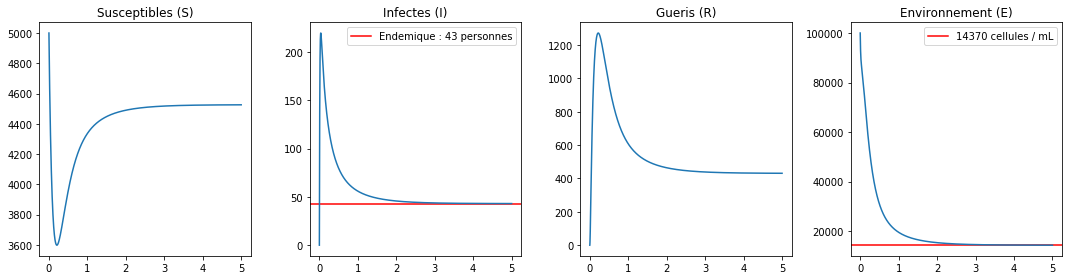

In [4]:
# Definition des conditions initiales
etats0 = [5000, 0, 0, 1e5]

# Le temps qui nous interesse - cinq ans
temps = np.linspace(0, 365 * 5, 10000)

# Simulation
solution = odeint(cholera, etats0, temps, args=(mu, kappa, gamma, xi, delta, beta))
dessiner(temps, solution)

Resultat : une epidemie se propage rapidement, infectant plus de 200 personnes simultanement au pic. 

L'epidemie diminue, et devient endemique - 43 personnes seront infectes a tout moment pour le futur.

L'environnement reste contamine.

# Scenario : pareil, sans naissances ou mortalite

Parmi les maladies qui conferent un niveau d'immunite apres infection, l'endemicite necessite un afflux de susceptibles. Sans cela, l'infection doit diminuer.

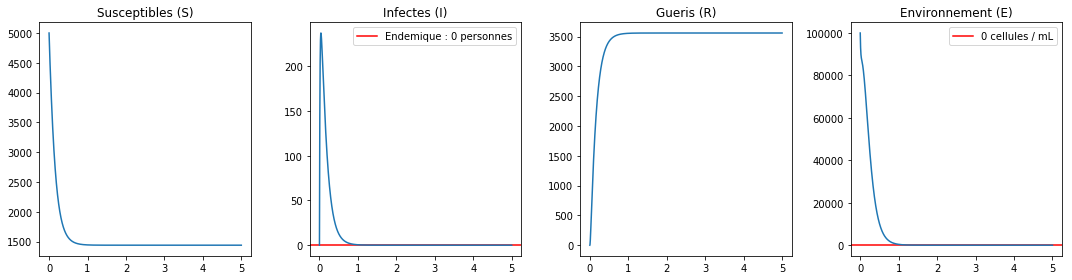

In [5]:
# Definition des conditions initiales
etats0 = [5000, 0, 0, 1e5]

# Le temps qui nous interesse - cinq ans
temps = np.linspace(0, 365 * 5, 10000)

# Simulation
solution = odeint(cholera, etats0, temps, args=(0, kappa, gamma, xi, delta, beta))
dessiner(temps, solution)

Sans naissances, l'infection passe parmi tous les individus ( $S(t)$ devient 0 ). L'epidemie s'etient en un an. 

Sans infectueux pour contribuer des bacteries a l'environnement, le nombre de cellules dans l'eau tombe a zero : la source d'eau n'est plus contaminee.